In [1]:
#plotting function
%matplotlib notebook

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os

#spec = 2048

#M = 9999 # number of signals

filein = "/local/2048_Angles_First.h5"
#filein = "/mnt/nndataset/SOUNDER_storepath/Anechoic_Data.h5"

with h5py.File(filein, "r") as f:
    folders = f.keys()
    #print("Folders in base: ", folders)
 

    #L = f.get('labels') #Retrieves the "labels" folder.
    #S = f.get('signals') #Retrieves "signals" folder.
    #print(f('dataset').keys())
    
    #Access generated data:
    data = f.get('generated_data')
    print(data.keys())
    #signal_data = data.get('dataset')
    signal_data = data.get('signal_0')
    gen_sigs = np.array(signal_data)
    print(data.keys())

    
    #data = np.array(S.get('rx_signals'))
    #dataset = data[0,0,:,:] #Sets the last two dimensions of the 4 dimensional array as the main 
                            #dataset
   

    #print(L.keys())
    #print(dataset.shape)
    #bandwidth = np.array(L.get('bandwidth'))
    #centers = np.array(L.get('center_freq')) #TODO: include frequency in name
    #SNR = np.array(L.get('SNR'))
    
    bandwidth = np.array(data.get('bandwidths'))
    centerf = np.array(data.get('centers'))
    start = np.array(data.get('starts')) / 2048
    stop = np.array(data.get('stops')) / 2048  # 2048 labels between 0 and 1 for loss
    
    print(signal_data)

<KeysViewHDF5 ['angles', 'bandwidths', 'centers', 'mods', 'signal_0', 'signal_1', 'starts', 'stops']>
<KeysViewHDF5 ['angles', 'bandwidths', 'centers', 'mods', 'signal_0', 'signal_1', 'starts', 'stops']>
<HDF5 dataset "signal_0": shape (30000, 2048), type "<c16">


In [3]:
dataset_fft = abs(np.fft.fftshift(np.fft.fft(gen_sigs), (1,))) #Pass this into NN.
#plt.plot(abs(dataset_fft[20]))
#plt.show()
#dataset_fft = abs(gen_sigs) #Pass this into NN.

# 2 Dimensional Array


# Creates a list
inputdata = np.array([dataset_fft, gen_sigs])
np.shape(inputdata)
inputdata = np.swapaxes(inputdata, 0, 1)
np.shape(inputdata)
inputdata = np.swapaxes(inputdata, 2, 1)

In [4]:
import os
num_threads = 24
os.environ["OMP_NUM_THREADS"] = "24"
os.environ["TF_NUM_INTRAOP_THREADS"] = "24"
os.environ["TF_NUM_INTEROP_THREADS"] = "24"

import tensorflow as tf

#config = tf.ConfigProto(intra_op_parallelism_threads=24,
#                        inter_op_parallelism_threads=2,
#                        allow_soft_placement=True,
#                        device_count = {'CPU': 24})
#session = tf.Session(config=config)
tf.config.threading.set_intra_op_parallelism_threads(24)
tf.config.threading.set_inter_op_parallelism_threads(24)
tf.config.set_soft_device_placement(True)

#from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D
import sys
import h5py
import random
import datetime

#Casts a list indexing from 0 to 9999 for each labeled dataset
#Bandwidth
#print(len(bandwidth))
# idx_bw = list(range(len(bandwidth)))
# idx_cf = list(range(len(centerf)))
# idx_start = list(range(len(start)))
# idx_stop = list(range(len(stop)))


idx = list(range(len(centerf)))
#Center Frequency
#idx_cf = list(range(len(centers)))
#Signal-to-Noise Ratio
#idx_SNR = list(range(len(SNR)))



#Shuffles indices of bandwidth, center freq, and SNR datasets
# random.shuffle(idx_bw)


# Ramdom seed 3700 is shuffling data correctly (omitted seed (5) due to it not shuffling)
random.Random(3700).shuffle(idx)
# random.Random(3700).shuffle(idx_start)
# random.Random(3700).shuffle(idx_stop)
#random.shuffle(idx_SNR)

#Splitting datasets (8000 assigned to training and 2000 to testing)
# training_indices_bw, testing_indices_bw = np.split(idx_bw, [int(0.8*len(idx_bw))])
training_indices, testing_indices = np.split(idx, [int(0.8*len(idx))])



training_data = []
training_labels = []
testing_data = []
testing_labels = []




for idx in training_indices:
    #iterate through all indices and print
    training_data.append(inputdata[idx])
    training_labels.append([start[idx], stop[idx], centerf[idx]])
    #print(idx)

    #put bandwidth training_data and training_labels into a numpy array.
training_data = tf.convert_to_tensor(np.array(training_data), dtype=tf.float32)
training_labels = tf.convert_to_tensor(np.array(training_labels), dtype=tf.float32)
#training_labels_bw = tf.reshape(training_labels_bw, training_labels_bw.get_shape()+(1,))
   
for idx in testing_indices:
    testing_data.append(inputdata[idx])
    testing_labels.append([start[idx], stop[idx], centerf[idx]])

testing_data = tf.convert_to_tensor(np.array(testing_data), dtype=tf.float32)
testing_labels = tf.convert_to_tensor(np.array(testing_labels), dtype=tf.float32)



print(np.shape(training_data))
print(np.shape(training_labels))


print(np.max(training_labels))



/local/dev/lib/python3.6/site-packages/tensorflow/python/framework/constant_op.py:106: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


(24000, 2048, 2)
(24000, 3)
0.9995117


In [5]:
from tensorflow import keras
#from tensorflow.keras.layers import Conv2D

finput = tf.keras.layers.Input(shape = (2048, 2), name = "finput") #2 dimensions
##Conv1D(number of kernels (try as few as 4 and go up by factors of 2, NoMachine?),
##length of the kernel (per discussion on board, try around 300), relu may not be the best, try other activation functions)
##Conv1D(How many kernels, points that define the kernels, activation....)

flayer1 = Conv1D(filters=64/2, kernel_size = 3, activation="tanh", name = "flayer1")(finput)
flayer1 = MaxPooling1D(2, name = "fPool1")(flayer1)

flayer2 = Conv1D(filters=128/2, kernel_size = 3, activation = "tanh", name = "flayer2")(flayer1)
flayer2 = MaxPooling1D(2, name = "fPool2")(flayer2)

flayer3 = Conv1D(filters=256/2, kernel_size = 3, activation = "tanh", name = "flayer3")(flayer2)
flayer3 = MaxPooling1D(2, name = "fPool3")(flayer3)

flayer4 = Conv1D(filters= 512/2, kernel_size = 3, activation = "tanh", name = "flayer4")(flayer3)
flayer4 = MaxPooling1D(2, name = "fPool4")(flayer4)   

flayer5 = Flatten(name = "fFlatten")(flayer4)

flayer6 = Dense(64, activation = "tanh", name = "fDense1")(flayer5)

foutput = Dense(3, activation = "tanh", name = "fDense2")(flayer6)


model = tf.keras.models.Model(inputs = finput, outputs = foutput)
model.summary()

#opt = keras.optimizers.Adam(learning_rate = 0.00000001)

opt = keras.optimizers.Adam(learning_rate = 0.000001)

#Johnathan Wintrode
model.compile(loss='mean_squared_error', optimizer = opt)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
finput (InputLayer)          [(None, 2048, 2)]         0         
_________________________________________________________________
flayer1 (Conv1D)             (None, 2046, 32)          224       
_________________________________________________________________
fPool1 (MaxPooling1D)        (None, 1023, 32)          0         
_________________________________________________________________
flayer2 (Conv1D)             (None, 1021, 64)          6208      
_________________________________________________________________
fPool2 (MaxPooling1D)        (None, 510, 64)           0         
_________________________________________________________________
flayer3 (Conv1D)             (None, 508, 128)          24704     
_________________________________________________________________
fPool3 (MaxPooling1D)        (None, 254, 128)          0     

In [ ]:
# IF YOUR KERNEL DIES
model = tf.keras.models.load_model(
    "/local/models/marlomodel.h5", custom_objects=None, compile=True, options=None
)

model.summary()

In [ ]:
print(training_data_cf)

In [6]:
filepath = "/local/models/marlomodel.h5"
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='max',
    save_best_only=True)
history_cf = model.fit(training_data, training_labels, epochs=1000, validation_data=(testing_data,testing_labels), callbacks = [callback] )

Epoch 1/1000
750/750 [==============================] - 19s 25ms/step - loss: 0.0330 - val_loss: 0.0201
Epoch 2/1000
750/750 [==============================] - 18s 24ms/step - loss: 0.0170 - val_loss: 0.0153
Epoch 3/1000
750/750 [==============================] - 18s 24ms/step - loss: 0.0136 - val_loss: 0.0126
Epoch 4/1000
750/750 [==============================] - 18s 24ms/step - loss: 0.0114 - val_loss: 0.0108
Epoch 5/1000
750/750 [==============================] - 18s 24ms/step - loss: 0.0099 - val_loss: 0.0096
Epoch 6/1000
750/750 [==============================] - 18s 24ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 7/1000
750/750 [==============================] - 18s 24ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 8/1000
750/750 [==============================] - 18s 25ms/step - loss: 0.0077 - val_loss: 0.0079
Epoch 9/1000
750/750 [==============================] - 18s 24ms/step - loss: 0.0072 - val_loss: 0.0075
Epoch 10/1000
750/750 [==============================] - 18s 25m

750/750 [==============================] - 18s 24ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 80/1000
750/750 [==============================] - 18s 24ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 81/1000
750/750 [==============================] - 18s 24ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 82/1000
750/750 [==============================] - 18s 24ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 83/1000
750/750 [==============================] - 18s 24ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 84/1000
750/750 [==============================] - 18s 24ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 85/1000
750/750 [==============================] - 18s 24ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 86/1000
750/750 [==============================] - 18s 24ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 87/1000
750/750 [==============================] - 18s 24ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 88/1000
750/750 [==============================] - 18s 24ms/ste

750/750 [==============================] - 18s 24ms/step - loss: 9.6244e-04 - val_loss: 0.0025
Epoch 157/1000
750/750 [==============================] - 18s 24ms/step - loss: 9.4508e-04 - val_loss: 0.0024
Epoch 158/1000
750/750 [==============================] - 18s 24ms/step - loss: 9.4582e-04 - val_loss: 0.0024
Epoch 159/1000
750/750 [==============================] - 18s 24ms/step - loss: 9.3033e-04 - val_loss: 0.0024
Epoch 160/1000
750/750 [==============================] - 18s 25ms/step - loss: 9.1288e-04 - val_loss: 0.0025
Epoch 161/1000
750/750 [==============================] - 18s 25ms/step - loss: 9.0817e-04 - val_loss: 0.0024
Epoch 162/1000
750/750 [==============================] - 18s 25ms/step - loss: 8.9391e-04 - val_loss: 0.0024
Epoch 163/1000
750/750 [==============================] - 18s 25ms/step - loss: 8.8153e-04 - val_loss: 0.0023
Epoch 164/1000
750/750 [==============================] - 18s 24ms/step - loss: 8.7404e-04 - val_loss: 0.0024
Epoch 165/1000
750/750 [=

750/750 [==============================] - 18s 25ms/step - loss: 4.1211e-04 - val_loss: 0.0017
Epoch 231/1000
750/750 [==============================] - 18s 24ms/step - loss: 4.1065e-04 - val_loss: 0.0017
Epoch 232/1000
750/750 [==============================] - 18s 25ms/step - loss: 4.0378e-04 - val_loss: 0.0017
Epoch 233/1000
750/750 [==============================] - 18s 25ms/step - loss: 4.0075e-04 - val_loss: 0.0017
Epoch 234/1000
750/750 [==============================] - 18s 24ms/step - loss: 3.9537e-04 - val_loss: 0.0017
Epoch 235/1000
750/750 [==============================] - 18s 24ms/step - loss: 3.9534e-04 - val_loss: 0.0017
Epoch 236/1000
750/750 [==============================] - 18s 24ms/step - loss: 3.8992e-04 - val_loss: 0.0017
Epoch 237/1000
750/750 [==============================] - 18s 24ms/step - loss: 3.8316e-04 - val_loss: 0.0017
Epoch 238/1000
750/750 [==============================] - 18s 24ms/step - loss: 3.8297e-04 - val_loss: 0.0017
Epoch 239/1000
750/750 [=

750/750 [==============================] - 18s 24ms/step - loss: 2.0660e-04 - val_loss: 0.0014
Epoch 305/1000
750/750 [==============================] - 18s 24ms/step - loss: 2.0708e-04 - val_loss: 0.0014
Epoch 306/1000
750/750 [==============================] - 18s 24ms/step - loss: 2.0523e-04 - val_loss: 0.0014
Epoch 307/1000
750/750 [==============================] - 18s 24ms/step - loss: 2.0304e-04 - val_loss: 0.0014
Epoch 308/1000
750/750 [==============================] - 18s 24ms/step - loss: 2.0056e-04 - val_loss: 0.0014
Epoch 309/1000
750/750 [==============================] - 18s 24ms/step - loss: 1.9993e-04 - val_loss: 0.0014
Epoch 310/1000
750/750 [==============================] - 18s 24ms/step - loss: 1.9741e-04 - val_loss: 0.0014
Epoch 311/1000
750/750 [==============================] - 18s 24ms/step - loss: 1.9630e-04 - val_loss: 0.0014
Epoch 312/1000
750/750 [==============================] - 18s 24ms/step - loss: 1.9497e-04 - val_loss: 0.0014
Epoch 313/1000
750/750 [=

750/750 [==============================] - 18s 25ms/step - loss: 1.1118e-04 - val_loss: 0.0012
Epoch 379/1000
750/750 [==============================] - 19s 25ms/step - loss: 1.1028e-04 - val_loss: 0.0012
Epoch 380/1000
750/750 [==============================] - 19s 25ms/step - loss: 1.1031e-04 - val_loss: 0.0012
Epoch 381/1000
750/750 [==============================] - 19s 25ms/step - loss: 1.0879e-04 - val_loss: 0.0012
Epoch 382/1000
750/750 [==============================] - 19s 25ms/step - loss: 1.0764e-04 - val_loss: 0.0012
Epoch 383/1000
750/750 [==============================] - 18s 25ms/step - loss: 1.0767e-04 - val_loss: 0.0012
Epoch 384/1000
750/750 [==============================] - 18s 24ms/step - loss: 1.0691e-04 - val_loss: 0.0012
Epoch 385/1000
750/750 [==============================] - 18s 24ms/step - loss: 1.0633e-04 - val_loss: 0.0012
Epoch 386/1000
750/750 [==============================] - 18s 25ms/step - loss: 1.0475e-04 - val_loss: 0.0012
Epoch 387/1000
750/750 [=

750/750 [==============================] - 18s 24ms/step - loss: 6.1648e-05 - val_loss: 0.0011
Epoch 453/1000
750/750 [==============================] - 18s 24ms/step - loss: 6.1613e-05 - val_loss: 0.0011
Epoch 454/1000
750/750 [==============================] - 18s 25ms/step - loss: 6.0771e-05 - val_loss: 0.0011
Epoch 455/1000
750/750 [==============================] - 19s 25ms/step - loss: 6.0798e-05 - val_loss: 0.0011
Epoch 456/1000
750/750 [==============================] - 19s 25ms/step - loss: 6.0074e-05 - val_loss: 0.0011
Epoch 457/1000
750/750 [==============================] - 19s 25ms/step - loss: 5.9512e-05 - val_loss: 0.0012
Epoch 458/1000
750/750 [==============================] - 19s 25ms/step - loss: 5.8527e-05 - val_loss: 0.0011
Epoch 459/1000
750/750 [==============================] - 18s 25ms/step - loss: 5.9017e-05 - val_loss: 0.0012
Epoch 460/1000
750/750 [==============================] - 18s 25ms/step - loss: 5.7688e-05 - val_loss: 0.0011
Epoch 461/1000
750/750 [=

750/750 [==============================] - 18s 25ms/step - loss: 3.5247e-05 - val_loss: 0.0011
Epoch 527/1000
750/750 [==============================] - 18s 24ms/step - loss: 3.4978e-05 - val_loss: 0.0011
Epoch 528/1000
750/750 [==============================] - 18s 25ms/step - loss: 3.4867e-05 - val_loss: 0.0011
Epoch 529/1000
750/750 [==============================] - 18s 25ms/step - loss: 3.4263e-05 - val_loss: 0.0011
Epoch 530/1000
750/750 [==============================] - 18s 24ms/step - loss: 3.3903e-05 - val_loss: 0.0011
Epoch 531/1000
750/750 [==============================] - 18s 24ms/step - loss: 3.4042e-05 - val_loss: 0.0011
Epoch 532/1000
750/750 [==============================] - 18s 25ms/step - loss: 3.3364e-05 - val_loss: 0.0011
Epoch 533/1000
750/750 [==============================] - 18s 25ms/step - loss: 3.3412e-05 - val_loss: 0.0011
Epoch 534/1000
750/750 [==============================] - 18s 24ms/step - loss: 3.3077e-05 - val_loss: 0.0011
Epoch 535/1000
750/750 [=

750/750 [==============================] - 18s 24ms/step - loss: 2.0689e-05 - val_loss: 0.0011
Epoch 601/1000
750/750 [==============================] - 18s 24ms/step - loss: 2.0073e-05 - val_loss: 0.0011
Epoch 602/1000
750/750 [==============================] - 18s 24ms/step - loss: 2.0090e-05 - val_loss: 0.0011
Epoch 603/1000
750/750 [==============================] - 19s 25ms/step - loss: 2.0038e-05 - val_loss: 0.0011
Epoch 604/1000
750/750 [==============================] - 19s 25ms/step - loss: 1.9843e-05 - val_loss: 0.0011
Epoch 605/1000
750/750 [==============================] - 19s 25ms/step - loss: 1.9506e-05 - val_loss: 0.0011
Epoch 606/1000
750/750 [==============================] - 19s 25ms/step - loss: 1.9515e-05 - val_loss: 0.0011
Epoch 607/1000
750/750 [==============================] - 19s 25ms/step - loss: 1.9193e-05 - val_loss: 0.0011
Epoch 608/1000
750/750 [==============================] - 18s 24ms/step - loss: 1.8896e-05 - val_loss: 0.0011
Epoch 609/1000
750/750 [=

750/750 [==============================] - 18s 24ms/step - loss: 1.2323e-05 - val_loss: 0.0011
Epoch 675/1000
750/750 [==============================] - 18s 24ms/step - loss: 1.1878e-05 - val_loss: 0.0011
Epoch 676/1000
750/750 [==============================] - 18s 24ms/step - loss: 1.1900e-05 - val_loss: 0.0011
Epoch 677/1000
750/750 [==============================] - 18s 24ms/step - loss: 1.1922e-05 - val_loss: 0.0011
Epoch 678/1000
750/750 [==============================] - 18s 24ms/step - loss: 1.1827e-05 - val_loss: 0.0011
Epoch 679/1000
750/750 [==============================] - 18s 24ms/step - loss: 1.1657e-05 - val_loss: 0.0011
Epoch 680/1000
750/750 [==============================] - 18s 24ms/step - loss: 1.1539e-05 - val_loss: 0.0011
Epoch 681/1000
750/750 [==============================] - 18s 24ms/step - loss: 1.1538e-05 - val_loss: 0.0011
Epoch 682/1000
750/750 [==============================] - 18s 24ms/step - loss: 1.1542e-05 - val_loss: 0.0011
Epoch 683/1000
750/750 [=

750/750 [==============================] - 19s 25ms/step - loss: 7.4356e-06 - val_loss: 0.0011
Epoch 749/1000
750/750 [==============================] - 19s 25ms/step - loss: 7.5227e-06 - val_loss: 0.0011
Epoch 750/1000
750/750 [==============================] - 18s 25ms/step - loss: 7.4371e-06 - val_loss: 0.0011
Epoch 751/1000
750/750 [==============================] - 18s 25ms/step - loss: 7.6452e-06 - val_loss: 0.0011
Epoch 752/1000
750/750 [==============================] - 18s 25ms/step - loss: 7.3372e-06 - val_loss: 0.0011
Epoch 753/1000
750/750 [==============================] - 18s 25ms/step - loss: 7.3753e-06 - val_loss: 0.0011
Epoch 754/1000
750/750 [==============================] - 18s 25ms/step - loss: 7.4071e-06 - val_loss: 0.0011
Epoch 755/1000
750/750 [==============================] - 18s 25ms/step - loss: 7.3647e-06 - val_loss: 0.0011
Epoch 756/1000
750/750 [==============================] - 18s 25ms/step - loss: 7.0893e-06 - val_loss: 0.0011
Epoch 757/1000
750/750 [=

750/750 [==============================] - 19s 25ms/step - loss: 4.9980e-06 - val_loss: 0.0010
Epoch 823/1000
750/750 [==============================] - 19s 25ms/step - loss: 5.2039e-06 - val_loss: 0.0010
Epoch 824/1000
750/750 [==============================] - 19s 25ms/step - loss: 4.9677e-06 - val_loss: 0.0011
Epoch 825/1000
750/750 [==============================] - 19s 25ms/step - loss: 5.0162e-06 - val_loss: 0.0010
Epoch 826/1000
750/750 [==============================] - 19s 25ms/step - loss: 4.8945e-06 - val_loss: 0.0010
Epoch 827/1000
750/750 [==============================] - 19s 25ms/step - loss: 5.1934e-06 - val_loss: 0.0010
Epoch 828/1000
750/750 [==============================] - 19s 25ms/step - loss: 5.1059e-06 - val_loss: 0.0010
Epoch 829/1000
750/750 [==============================] - 19s 25ms/step - loss: 4.7502e-06 - val_loss: 0.0010
Epoch 830/1000
750/750 [==============================] - 19s 25ms/step - loss: 4.7087e-06 - val_loss: 0.0010
Epoch 831/1000
750/750 [=

750/750 [==============================] - 18s 25ms/step - loss: 3.4974e-06 - val_loss: 0.0010
Epoch 897/1000
750/750 [==============================] - 18s 25ms/step - loss: 3.7808e-06 - val_loss: 0.0010
Epoch 898/1000
750/750 [==============================] - 18s 25ms/step - loss: 3.8332e-06 - val_loss: 0.0010
Epoch 899/1000
750/750 [==============================] - 18s 25ms/step - loss: 3.4793e-06 - val_loss: 0.0010
Epoch 900/1000
750/750 [==============================] - 19s 25ms/step - loss: 3.6044e-06 - val_loss: 0.0010
Epoch 901/1000
750/750 [==============================] - 19s 25ms/step - loss: 3.6921e-06 - val_loss: 0.0010
Epoch 902/1000
750/750 [==============================] - 19s 25ms/step - loss: 3.5778e-06 - val_loss: 0.0010
Epoch 903/1000
750/750 [==============================] - 19s 25ms/step - loss: 3.6922e-06 - val_loss: 0.0010
Epoch 904/1000
750/750 [==============================] - 19s 25ms/step - loss: 3.4154e-06 - val_loss: 0.0010
Epoch 905/1000
750/750 [=

750/750 [==============================] - 18s 25ms/step - loss: 2.9837e-06 - val_loss: 0.0010
Epoch 971/1000
750/750 [==============================] - 18s 25ms/step - loss: 2.7690e-06 - val_loss: 0.0010
Epoch 972/1000
750/750 [==============================] - 18s 24ms/step - loss: 2.6467e-06 - val_loss: 0.0010
Epoch 973/1000
750/750 [==============================] - 18s 24ms/step - loss: 3.0325e-06 - val_loss: 0.0010
Epoch 974/1000
750/750 [==============================] - 18s 24ms/step - loss: 2.7951e-06 - val_loss: 0.0010
Epoch 975/1000
750/750 [==============================] - 18s 24ms/step - loss: 2.7074e-06 - val_loss: 0.0010
Epoch 976/1000
750/750 [==============================] - 18s 24ms/step - loss: 2.9682e-06 - val_loss: 0.0010
Epoch 977/1000
750/750 [==============================] - 18s 24ms/step - loss: 2.9557e-06 - val_loss: 0.0010
Epoch 978/1000
750/750 [==============================] - 18s 25ms/step - loss: 2.6464e-06 - val_loss: 0.0010
Epoch 979/1000
750/750 [=

In [7]:
loss = model.evaluate(testing_data, batch_size=128)
print("test loss, test acc:", loss)
print(loss)
print(history_cf.history)

#mean square
loss = history_cf.history['loss']
val_loss = history_cf.history['val_loss']
#epochs = range(1,9)


#Root mean square
sqrt_loss = np.sqrt(loss)
sqrt_val_loss = np.sqrt(val_loss)


plt.loglog(sqrt_loss, 'r', label='Training Loss')
plt.loglog(sqrt_val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

47/47 [==============================] - 0s 606us/step - loss: 0.0000e+00
test loss, test acc: 0.0
0.0
{'loss': [0.033042293041944504, 0.017024090513586998, 0.013571960851550102, 0.011352653615176678, 0.009909597225487232, 0.008929656818509102, 0.008222389034926891, 0.00768100144341588, 0.0072471750900149345, 0.006870483513921499, 0.0065536778420209885, 0.00627788295969367, 0.0060424404218792915, 0.0058051408268511295, 0.005602207034826279, 0.00541350431740284, 0.005242181941866875, 0.005066723097115755, 0.0049229878932237625, 0.004784814082086086, 0.004628073889762163, 0.004511839710175991, 0.004389401525259018, 0.004286668263375759, 0.00419469503685832, 0.004098948556929827, 0.004019635263830423, 0.0039424472488462925, 0.003883732482790947, 0.0038108399603515863, 0.0037544392980635166, 0.003689763369038701, 0.0036374435294419527, 0.0035780491307377815, 0.003544272854924202, 0.0034935257863253355, 0.003440706292167306, 0.003386555938050151, 0.00334801129065454, 0.003310894127935171, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


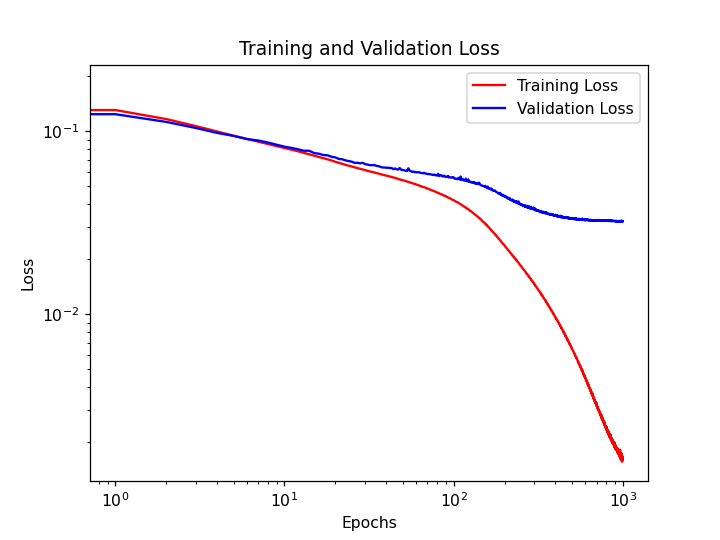

In [8]:
plt.figure()
plt.loglog(sqrt_loss, 'r', label='Training Loss')
plt.loglog(sqrt_val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
#Random integer input for checking random indices.

random_index = random.randint(0,len(testing_labels)-1)

print("Index value:", random_index)

predict_cf = model.predict(testing_data)

print("Inferred value:", predict_cf[random_index])
print("Actual value:", testing_labels[random_index])
print(centerf[random_index])

Index value: 465
Inferred value: [ 0.10306944  0.86461383 -0.00768701]
Actual value: tf.Tensor([ 0.06494141  0.86621094 -0.0105684 ], shape=(3,), dtype=float32)
-0.0044978


In [10]:
#Random integer input for checking random indices.

random_index = random.randint(0,len(testing_labels)-1)

print("Index value:", random_index)

predict_cf = model.predict(testing_data)

print("Inferred value:", predict_cf[random_index])
print("Actual value:", testing_labels[random_index])
print(centerf[random_index])

Index value: 442
Inferred value: [ 0.10509989  0.49553308 -0.06138049]
Actual value: tf.Tensor([ 0.12890625  0.52197266 -0.0540468 ], shape=(3,), dtype=float32)
0.0629406


In [11]:
#Random integer input for checking random indices.

random_index = random.randint(0,len(testing_labels)-1)

print("Index value:", random_index)

predict_cf = model.predict(testing_data)

print("Inferred value:", predict_cf[random_index])
print("Actual value:", testing_labels[random_index])
print(centerf[random_index])

Index value: 2676
Inferred value: [0.70711535 0.99411947 0.05848968]
Actual value: tf.Tensor([0.7573242 0.9995117 0.034471 ], shape=(3,), dtype=float32)
0.0438954


In [12]:
#Random integer input for checking random indices.

random_index = random.randint(0,len(testing_labels)-1)

print("Index value:", random_index)

predict_cf = model.predict(testing_data)

print("Inferred value:", predict_cf[random_index])
print("Actual value:", testing_labels[random_index])
print(centerf[random_index])

Index value: 4650
Inferred value: [0.0175686  0.24794611 0.10519253]
Actual value: tf.Tensor([0.03027344 0.30371094 0.121795  ], shape=(3,), dtype=float32)
0.080489


In [13]:
#Random integer input for checking random indices.

random_index = random.randint(0,len(testing_labels)-1)

print("Index value:", random_index)

predict_cf = model.predict(testing_data)

print("Inferred value:", predict_cf[random_index])
print("Actual value:", testing_labels[random_index])
print(centerf[random_index])

Index value: 1732
Inferred value: [ 0.6111053   0.9897301  -0.04330744]
Actual value: tf.Tensor([ 0.5908203   0.98876953 -0.049355  ], shape=(3,), dtype=float32)
-0.0185322


In [ ]:
loss_cf = model.evaluate(testing_data_cf, batch_size=128)
print("test loss, test acc:", loss_cf)
print(loss_cf)
print(history_cf.history)

#mean square
loss_cf = history_cf.history['loss']
val_loss_cf = history_cf.history['val_loss']
#epochs = range(1,9)


#Root mean square
sqrt_loss = np.sqrt(loss_cf)
sqrt_val_loss = np.sqrt(val_loss_cf)

In [ ]:
plt.figure()
plt.loglog(sqrt_loss, 'r', label='Training Loss')
plt.loglog(sqrt_val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
model.save('timeandfmodel.h5')